<h1> 다음에 볼 영화 예측하기 <h1>

###  Session-Based Recommendation

Session-Based Recommendation은 말 그대로 세션 데이터를 기반으로 유저가 다음에 클릭 또는 구매할 아이템을 예측하는 추천을 말한다. 

Session이란 앞에서 살펴보았듯이 유저가 서비스를 이용하면서 발생하는 중요한 정보를 담은 데이터를 말하며, 서버 쪽에 저장된다.

유저의 행동 데이터들은 유저측 브라우저를 통해 쿠키의 형태로 저장되는데 쿠키는 세션과 상호작용하면서 정보를 주고 받는다.

프로젝트 폴더를 만들고, 데이터 폴더에서 프로젝트 폴더로 링크를 연결

$ mkdir -p ~/aiffel/EXPLORATION/12/yoochoose/data

$ ln -s ~/data/* ~/aiffel/EXPLORATION/12/yoochoose/data

In [1]:
# 데이터 설명(README)를 읽어 봅니다. 
import os
f = open(os.getenv('HOME')+'/aiffel/EXPLORATION/12/yoochoose/data/dataset-README.txt', 'r')
while True:
    line = f.readline()
    if not line: break
    print(line)
f.close()

﻿SUMMARY




This dataset was constructed by YOOCHOOSE GmbH to support participants in the RecSys Challenge 2015.

See  http://recsys.yoochoose.net for details about the challenge.



The YOOCHOOSE dataset contain a collection of sessions from a retailer, where each session

is encapsulating the click events that the user performed in the session.

For some of the sessions, there are also buy events; means that the session ended

with the user bought something from the web shop. The data was collected during several

months in the year of 2014, reflecting the clicks and purchases performed by the users

of an on-line retailer in Europe.  To protect end users privacy, as well as the retailer,

all numbers have been modified. Do not try to reveal the identity of the retailer.



LICENSE


This dataset is licensed under the Creative Commons Attribution-NonCommercial-NoDerivatives 4.0

International License. To view a copy of this license, visit http://creativecommons.org/licenses/by-nc-nd

데이터 설명을 읽어보면 몇 가지 주목할만한 점으로

- 유저에 대한 정보를 전혀 알 수 없습니다. (성별, 나이, 장소, 마지막 접속 날짜, 이전 구매 내역 등등 )

- 아이템에 대한 정보도 전혀 알 수 없습니다. (실제로 어떤 물건인지, 사진이나 설명, 가격)

이와 달리 유저에 대한 정보를 알 수 있는 경우는 보통 Sequential Recommendation 이라고 구별해서 부르기도 한다.

유저와 아이템의 추가 정보를 Sequential Recommendation 모델에 적용하는 분야는 Context-Aware 라는 키워드로 활발히 연구되고 있다.

또한 E-Commerce 데이터의 경우 다음과 같은 특징을 갖는다.

- 비로그인 상태로 탐색하는 유저가 많습니다.

- 로그인 상태로 탐색한다고 할지라도 접속할 때 마다 탐색하는 의도가 뚜렷하게 다릅니다.

즉, 마우스를 사야겠다고 마음먹고 탐색한 이력이 칫솔을 사야겠다 생각하고 탐색하는 경우에 도움이 되지 않는다.

## Data Preprocess

### Data Load



In [2]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/EXPLORATION/12/yoochoose/data') 
train_path = data_path / 'yoochoose-clicks.dat'
train_path

PosixPath('/aiffel/aiffel/EXPLORATION/12/yoochoose/data/yoochoose-clicks.dat')

In [4]:
def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep=',', header=None, usecols=[0, 1, 2],
                       parse_dates=[1], dtype={0: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['SessionId', 'Time', 'ItemId']
    return data

In [5]:
# 시간이 좀 걸릴 수 있습니다. 메모리도 10GB 가까이 소요될 수 있으니 메모리 상태에 주의해 주세요.  

data = load_data(train_path, None)
data.sort_values(['SessionId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,SessionId,Time,ItemId
0,1,2014-04-07 10:51:09.277000+00:00,214536502
1,1,2014-04-07 10:54:09.868000+00:00,214536500
2,1,2014-04-07 10:54:46.998000+00:00,214536506
3,1,2014-04-07 10:57:00.306000+00:00,214577561
4,2,2014-04-07 13:56:37.614000+00:00,214662742
...,...,...,...
32230487,11562158,2014-09-26 04:50:29.172000+00:00,214849132
32230488,11562158,2014-09-26 04:52:21.900000+00:00,214854774
32230489,11562158,2014-09-26 05:16:32.904000+00:00,214849132
32230490,11562159,2014-09-26 19:16:28.897000+00:00,214849132


추천시스템을 구축할 때 가장 먼저 확인해 볼 것은 유저수(세션 수)와 아이템 수 이다.

In [6]:
data['SessionId'].nunique(), data['ItemId'].nunique()

(9249729, 52739)

### Session Length

In [7]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
1           4
2           6
3           3
4           2
6           2
           ..
11562156    2
11562157    2
11562158    3
11562159    1
11562161    1
Length: 9249729, dtype: int64

session_length란 같은 SessionId를 공유하는 데이터 row의 개수를 의미한다. 

SessionId란 브라우저에서 웹서버로 접속할 때 항상 포함하게 되는 유저 구분자인데, 로그인하지 않았기 때문에 이 사용자가 누군지는 알수 없어도, 최소한 특정 사용자의 행동을 SessionId 기준으로 모아서 분류해낼 수는 있다. 

따라서 여기서 session_length란 해당 세션의 사용자가 그 세션 동안 몇번의 액션을 취했는지(몇개의 상품정보를 클릭했는지)의 의미가 된다.

In [8]:
session_length.median(), session_length.mean()

(2.0, 3.568098481587947)

In [9]:
session_length.min(), session_length.max()

(1, 200)

In [10]:
session_length.quantile(0.999)

41.0

각 세션의 길이는 보통 2~3 정도로 확인되며, 99.9% 세션은 길이가 41이하인데 반하여, 길이가 200인 세션이 존재하기 때문에 체크해보자.

In [11]:
long_session = session_length[session_length==200].index[0]
data[data['SessionId']==long_session]

,SessionId,Time,ItemId
580293,189448,2014-04-01 08:56:28.983000+00:00,214830392
580294,189448,2014-04-01 08:56:31.815000+00:00,214830392
580295,189448,2014-04-01 08:57:08.301000+00:00,214830392
580296,189448,2014-04-01 08:57:10.338000+00:00,214830392
580297,189448,2014-04-01 08:58:01.728000+00:00,214830390
...,...,...,...
580488,189448,2014-04-01 10:35:52.400000+00:00,214830137
580489,189448,2014-04-01 10:37:15.094000+00:00,214830118
580490,189448,2014-04-01 10:37:35.955000+00:00,214830118
580491,189448,2014-04-01 10:37:37.098000+00:00,214830118


매우 짧은 간격으로 지속적으로 클릭을 1시간 30분 가량 지속하고 있습니다.
유저들의 서비스 이용행태는 다양하기 때문에 데이터 전처리를 어떻게 할지는 모델을 만드는 사람이 판단해야 합니다.
e.g.) 음악 데이터의 경우 어떤 사람은 하루종일 랜덤재생을 할 수도 있습니다. 이 유저의 데이터를 그대로 사용하는 게 좋을까요?
e.g.) 어떤 상품의 경우 1분 내에 20명이 10점을 주고 나갈 수도 있습니다. 이 상품을 팔기 위해 조작하고 있는 건 아닐까요?

너무 긴 세션을 제거할 수도 있고 포함시킬 수도 있습니다. 어떻게 하면 좋을지 판단해보세요.

세션 길이에 대한 감을 더 잘 파악하기 위해 시각화를 해보겠습니다. 아래는 세션길이 기준 하위 99.9%까지의 분포 누적합을 시각화한 것입니다.

In [12]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

1     0.136189
2     0.520858
3     0.695280
4     0.796461
5     0.855125
6     0.894389
7     0.920036
8     0.938321
9     0.951293
10    0.961084
11    0.968267
12    0.973959
13    0.978320
14    0.981815
15    0.984587
16    0.986837
17    0.988673
18    0.990201
19    0.991460
20    0.992520
21    0.993436
22    0.994207
23    0.994871
24    0.995444
25    0.995920
26    0.996342
27    0.996714
28    0.997042
29    0.997330
30    0.997577
31    0.997796
32    0.998001
33    0.998177
34    0.998327
35    0.998461
36    0.998590
37    0.998706
38    0.998805
39    0.998896
40    0.998981
dtype: float64

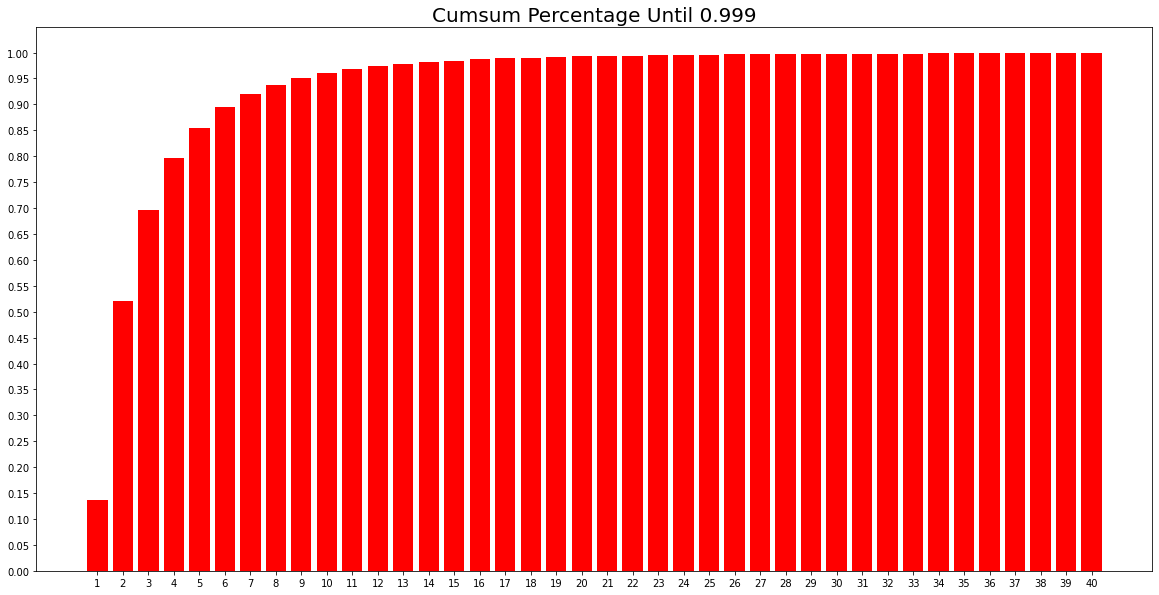

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

### Session Time

- 어떤 유저가 아이폰을 구매하려고 합니다. 2020년 5월에는 아이폰SE2를 구매하려는 사람이 많을 것입니다.
- 그러나 그로부터 몇달 후면 아이폰 12의 구매량이 엄청나게 증가하게 될 것입니다.
- 영화나 드라마 역시 마찬가지입니다. 유저들의 소비 패턴을 금방금방 변합니다.
- 이런 이유 때문에 추천시스템을 구축할 때에는 최근 소비 트렌드를 학습하는 것이 중요합니다. 이번에는 데이터가 발생한 시간에 대해 알아봅시다.

그렇다면 우리가 다루려는 데이터의 시간 관련 정보를 확인해 보자.

In [14]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2014-04-01 03:00:00.124000+00:00
2014-09-30 02:59:59.430000+00:00


데이터 설명대로 6개월치 데이터가 있는데, 계획대로 1개월치 말고 6개월치 데이터를 사용하면 성능이 더 좋아질까?

In [15]:
type(latest)

pandas._libs.tslibs.timestamps.Timestamp

latest는 Timestamp 객체이기 때문에 int 객체와의 사칙연산을 지원하지 않는다. 날짜끼리의 차이를 구하고 싶을 때는 datetime 라이브러리의 timedelta 객체를 사용한다.

In [16]:
month_ago = latest - dt.timedelta(30)     # 최종 날짜로부터 30일 이전 날짜를 구한다.  
data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data

,SessionId,Time,ItemId
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420
26838214,9194112,2014-09-01 13:26:36.292000+00:00,214853422
...,...,...,...
32230487,11562158,2014-09-26 04:50:29.172000+00:00,214849132
32230488,11562158,2014-09-26 04:52:21.900000+00:00,214854774
32230489,11562158,2014-09-26 05:16:32.904000+00:00,214849132
32230490,11562159,2014-09-26 19:16:28.897000+00:00,214849132


### Data Cleansing

앞의 내용을 살펴보니 길이가 1인 세션도 발견되었는데, 우리의 목적은 유저가 최소 1개 이상 클릭했을 때 다음 클릭을 예측하는 것이므로 길이가 1인 세션은 제거해준다.

너무 적게 클릭된 아이템은 이상한 아이템일 가능성이 있으니 이 역시 제거해준다.

In [17]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [18]:
data = cleanse_recursive(data, shortest=2, least_click=5)
data

,SessionId,Time,ItemId
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420
26838202,9194123,2014-08-31 19:26:57.386000+00:00,214601207
...,...,...,...
32230485,11562157,2014-09-25 12:31:10.391000+00:00,214580372
32230486,11562157,2014-09-25 12:31:29.679000+00:00,214516012
32230487,11562158,2014-09-26 04:50:29.172000+00:00,214849132
32230488,11562158,2014-09-26 04:52:21.900000+00:00,214854774


### Train/ Valid/ Test split

모델 평가를 위해 Valid Set과 Test Set을 만들어 보자. 대회에서 Test Set을 제공해주고 있다.

In [19]:
test_path = data_path / 'yoochoose-test.dat'
test= load_data(test_path)
test['Time'].min(), test['Time'].max()

(Timestamp('2014-04-01 03:00:08.250000+0000', tz='UTC'),
 Timestamp('2014-09-30 02:59:23.866000+0000', tz='UTC'))

Test 셋을 살펴보니 Training 셋과 기간이 겹치지만 앞에서 말했듯이 추천 시스템은 지금 잘 예측하는 게 중요하다.

1달 전에 성능이 좋은 모델을 지금 쓰면 맞지 않을 수가 있는데, 사용자들의 소비 패턴이 달라지기 때문이다.

이런 이유로 Session-Based Recommendation에서는 기간에 따라 Train/ Valid/ Test 셋을 나누기도 하는데, 이번 자료에서는 가장 마지막 1일 기간 동안을 Test로, 2일전부터 1일전 까지를 valid set으로 나눈다.

In [20]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [21]:
tr, test = split_by_date(data, n_days=1)
tr, val = split_by_date(tr, n_days=1)

In [22]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [23]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 5125100
	 Sessions: 1243431
	 Items: 20153
	 First Time : 2014-08-31 03:00:01.111000+00:00
	 Last Time : 2014-09-28 02:57:34.348000+00:00

* valid Set Stats Info
	 Events: 58074
	 Sessions: 12350
	 Items: 6232
	 First Time : 2014-09-28 03:00:25.298000+00:00
	 Last Time : 2014-09-29 02:58:27.660000+00:00

* test Set Stats Info
	 Events: 71009
	 Sessions: 15289
	 Items: 6580
	 First Time : 2014-09-29 02:37:20.695000+00:00
	 Last Time : 2014-09-30 02:59:59.430000+00:00



In [24]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

데이터를 저장한 다음 data pipeline을 구축하는 단계로 넘어가보면....

In [25]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## 논문소개(GRU4REC)

이번 자료에서 사용할 모델은 2016년 ICLR에 공개된 SESSION-BASED RECOMMENDATIONS WITH RECURRENT NEURAL NETWORKS 로,Session Data에서는 처음으로 RNN 계열 모델을 적용하여 발표했다.

모델 구조는 아래 그림과 같으며, 여러 RNN 계열의 모델(e.g. LSTM)이 있겠지만 저자가 실험해본 결과 GRU의 성능이 제일 좋았다고 한다.

또한 Embedding Layer를 사용하지 않았을 때가 사용했을 때보다 성능이 좋았다고 한다. Embedding Layer를 사용하지 않고 One-hot Encoding만 사용하겠다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/12/etc/model.max-800x600.png?raw=true)


대신 추천 데이터의 특징 몇 가지를 살려 모델링을 했는데..

### Session-Parallel Mini-Batches :

위에서 보았듯이 Session의 길이는 매우 짧은 것들이 대부분이지만 매우 긴 것들도 있다.

이 세션들을 데이터 샘플 하나로 보고 mini-batch를 구성하여 input으로 넣는다면 길이가 제일 긴 세션의 연산이 끝날 때까지 짧은 세션들이 기다려야 한다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/12/etc/input1.max-800x600.png?raw=true)

위 그림에서 Session 1, 2, 3을 하나의 mini-batch로 만든다면, 이 미니배치의 연산은 Session 3의 연산이 끝나야 끝나는 식이다.

논문의 저자는 대신 Session-Parallel Mini-Batches를 제안하는데, 이름처럼 Session이 끝날 때까지 기다리지 않고 병렬적으로 계산하자는 뜻으로
아래 그림에서 session2가 끝나면 session4가 시작하는 방식이다.

이렇게 구성했을 때 Mini-Batch의 shape은 (3, 1, 1)이 되고 RNN cell의 state가 1개로만 이루어진다.

또한 Tensorflow 기준으로 RNN을 만들 때 stateful=True 옵션을 사용하고 2처럼 세션이 끝나면 state를 0으로 만들어 줍니다. 

RNN API 보기 뒷부분에서 이 부분에 대한 코딩을 어떻게 했는지 봅시다.

![](https://github.com/MulderKim/EXPLORATION/blob/main/12/etc/input2.max-800x600.png?raw=true)

### SAMPLING ON THE OUTPUT : 

Negative Sampling와 같은 개념으로, Item의 수가 많기 때문에 Loss를 계산할 때 모든 아이템을 비교하지 않고 인기도를 고려하여 Sampling한다. 

### Ranking Loss 

Session-Based Recommendation Task를 여러 아이템 중 다음 아이템이 무엇인지 Classification하는 Task로 생각할 수도 있으나, 여러 아이템을 관련도 순으로 랭킹을 매겨서 높은 랭킹의 아이템을 추천하는 Task로도 생각할 수 있다.

추천 시스템 연구 분야에서는 이렇게 Ranking을 맞추는 objective function에 대한 연구가 있었고 논문의 저자 역시 이런 Loss를 사용했다.

그러나 이번 자료에서는 Classification Task로 보고 Cross-Entropy Loss를 사용할 것이다.

## Data Pipeline

Session-Parallel Mini-Batch 를 구현

### SessionDataset



In [26]:
# 데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만든다.

class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

train데이터로 SessionDataset 객체를 만들고 인스턴스 변수들을 살펴보면, click_offsets 변수는 각 세션이 시작된 인덱스를 담고 있으며, session_idx 변수는 각 세션을 인덱싱한 np.array 이다.

In [27]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,SessionId,Time,ItemId,item_idx
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420,0
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942,1
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878,2
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420,0
26838202,9194123,2014-08-31 19:26:57.386000+00:00,214601207,3
26838203,9194123,2014-08-31 19:34:37.068000+00:00,214510689,4
26838193,9194124,2014-08-31 19:14:28.308000+00:00,214849327,5
26838194,9194124,2014-08-31 19:16:31.114000+00:00,214828970,6
26838196,9194127,2014-09-01 15:36:11.651000+00:00,214845997,7
26838197,9194127,2014-09-01 15:38:00.222000+00:00,214845997,7


In [28]:
tr_dataset.click_offsets

array([      0,       4,       6, ..., 5125095, 5125097, 5125100],
      dtype=int32)

In [29]:
tr_dataset.session_idx

array([      0,       1,       2, ..., 1243428, 1243429, 1243430])

### SessionDataLoader

SessionDataset 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만들며, __iter__ 메소드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 yield한다.

mask는 후에 RNN Cell State를 초기화 하는데 사용한다.

In [30]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [31]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,SessionId,Time,ItemId,item_idx
26837834,9194111,2014-08-31 17:40:46.805000+00:00,214853420,0
26837835,9194111,2014-08-31 17:42:26.089000+00:00,214850942,1
26837836,9194111,2014-08-31 17:44:06.583000+00:00,214829878,2
26837837,9194111,2014-08-31 17:48:49.873000+00:00,214853420,0
26838202,9194123,2014-08-31 19:26:57.386000+00:00,214601207,3
26838203,9194123,2014-08-31 19:34:37.068000+00:00,214510689,4
26838193,9194124,2014-08-31 19:14:28.308000+00:00,214849327,5
26838194,9194124,2014-08-31 19:16:31.114000+00:00,214828970,6
26838196,9194127,2014-09-01 15:36:11.651000+00:00,214845997,7
26838197,9194127,2014-09-01 15:38:00.222000+00:00,214845997,7


In [32]:
iter_ex = iter(tr_data_loader)

아래 셀을 반복 실행하면 next가 계속 다음 데이터를 만듭니다.
input, output, mask의 감을 잡아 봅시다.

In [33]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [0 3 5 7]
Label Item Idx are :       [1 4 6 7]
Previous Masked Input Idx are []


## Modeling

### Evaluation Metric

모델 성능에 대한 지표로 precision이나 recall이 있으며, Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋다.

이 때문에 recall의 개념을 확장한 recall@k 지표, precision의 개념을 확장한 Mean Average Precision@k 지표 등을 사용한다.

추천에서는 몇 번째로 맞추느냐도 중요한데, 구글에서 검색했을 때 1페이지에 원하는 결과가 나오지 않고 2페이지에 나온다면 유저 반응이 크게 떨어질 것이다.

따라서 순서에 민감한 지표인 MRR, NDCG 같은 지표도 사용한다.

이번 자료에서는 MRR과 Recall@k를 사용할 것이며, MRR은 정답 아이템이 나온 순번의 역수 값이다.

따라서 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고 뒤쪽에 나오거나 안나온다면 지표가 낮아질 것이다.

In [34]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### Model Architecture

모델 구조가 간단한 편이므로 Functional하게 모델을 만들어보면..

In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [36]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

모델에 사용할 hyper-parameter를 class형식으로 관리한다.

In [37]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [38]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(2048, 1, 20153)]        0         
_________________________________________________________________
GRU (GRU)                    [(2048, 50), (2048, 50)]  3030750   
_________________________________________________________________
dropout (Dropout)            (2048, 50)                0         
_________________________________________________________________
dense (Dense)                (2048, 20153)             1027803   
Total params: 4,058,553
Trainable params: 4,058,553
Non-trainable params: 0
_________________________________________________________________


### Model Training

지금까지 준비한 데이터셋과 모델을 통해 학습을 진행해 보면, 학습은 총 3epoch 진행되며, 대략 1시간 가량 소요될 예정이다. 

3epoch면 모델이 충분히 수렴하여 성능이 확인될 만큼은 아니나, 모델 학습이 정상적으로 진행되고 있음을 확인할 수 있는 수준은 될 것이며, 배치 사이즈나 epoch 등의 설정은 위의 args에서 관리하므로 진행전 값을 확인해야 한다.

In [39]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [42]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Train:   0%|          | 0/1895 [00:00<?, ?it/s]

	 - Recall@20 epoch 1: 0.671013
	 - MRR@20    epoch 1: 0.288608



Train:   0%|          | 0/1895 [00:00<?, ?it/s]

	 - Recall@20 epoch 2: 0.690717
	 - MRR@20    epoch 2: 0.303885



Evaluation:  77%|███████▋  | 17/22 [02:13<00:39,  7.87s/it]

	 - Recall@20 epoch 3: 0.701861
	 - MRR@20    epoch 3: 0.311620



### Inference

학습이 완료되었으면 지금까지 학습한 모델이 테스트셋에 대해서도 유사한 수준의 성능을 내는지 검증해 보자.

In [43]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  81%|████████▏ | 22/27 [02:53<00:39,  7.90s/it]

	 - Recall@20: 0.701860
	 - MRR@20: 0.302602



## 프로젝트 - Movielens 영화 SBR


Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작

- 데이터 확인

$ ls -l ~/data

- 프로젝트 폴더 생성

$ mkdir -p ~/aiffel/EXPLORATION/12/yoochoose

- 프로젝트 폴더로 데이터 폴더 링크 연결

$ ln -s ~/data/* ~/aiffel/EXPLORATION/12/yoochoose/data

라이브러리 불러오기

In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from pathlib import Path
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/EXPLORATION/12/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.

data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


- 여기서 이전 실습내역과 가장 크게 다른 부분은 SessionID 대신 UserID 항목이 들어갔다는 점이다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있어서 이번에는 UserID가 SessionID 역할을 해야 한다.

- Rating 정보가 포함되어 있는데, 이전 실습내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있지만, 직전에 봤던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 한다.

- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있다.

위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 본다.

### Step 1. 데이터의 전처리

- session id : 시퀀스데이터
- 세션 하나에 여러개 아이템이 존재할 수 있음
- userid 가 sessinid와 같은 역할
- rating : 제외할 수도 있고, 반영할 수도 있음, 비슷한 영화를 선택한 것일 수도, rating이 낮은 데이터는 어떻게 처리할 것인가도 생각
- time : utc time, 1970년 1월1일부터 경과된 초단위시간


위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행한다.

특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의한다.

In [3]:
# 유저, 아이템 수
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [4]:
#session length
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [5]:
print('중앙값 : ', session_length.median())
print('평균값 : ', session_length.mean())
print('최솟값 : ', session_length.min())
print('최댓값 : ', session_length.max())

중앙값 :  96.0
평균값 :  165.5975165562914
최솟값 :  20
최댓값 :  2314


In [6]:
session_length.quantile(0.999)

1343.181000000005

In [7]:
# 가장 많이 남긴 유저 체크
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


In [8]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

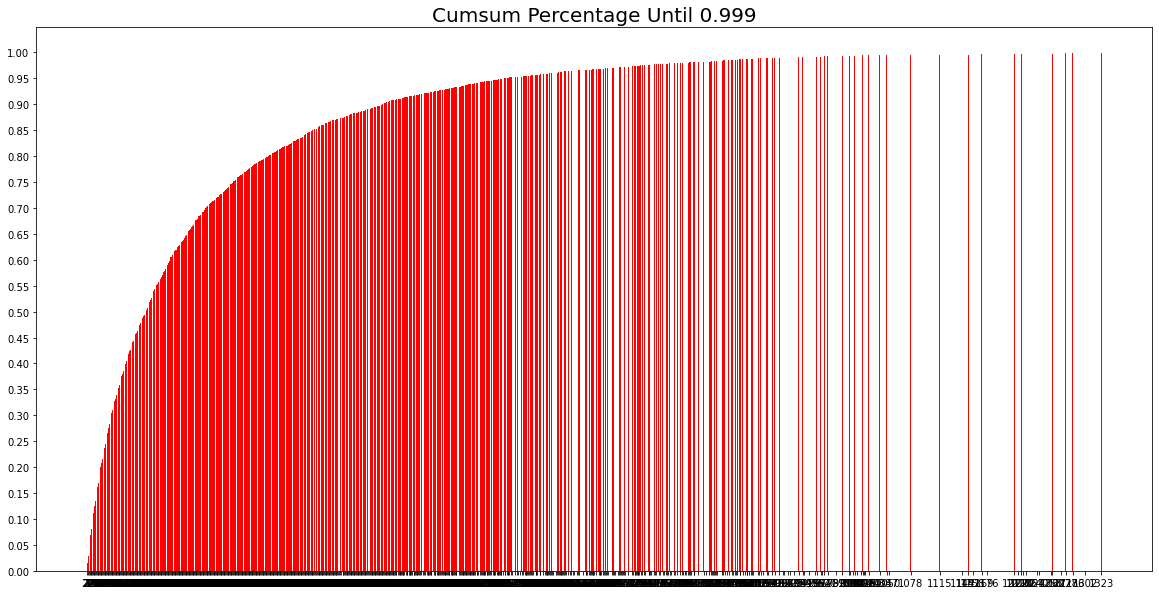

In [9]:
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index, height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [10]:
# oldset, latest 구하기
data['Time'] = pd.to_datetime(data['Time'], unit='s')
data

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43
...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29
999988,6040,1921,4,2001-08-10 14:41:04
1000172,6040,1784,3,2001-08-10 14:41:04
1000167,6040,161,3,2001-08-10 14:41:26


In [11]:
oldset, latest = data['Time'].min(), data['Time'].max()
oldset, latest

(Timestamp('2000-04-25 23:05:32'), Timestamp('2003-02-28 17:49:50'))

In [12]:
# 최종 날짜로부터 30일 이전 날짜를 구한 후 그 날짜 이후의 데이터 개수 확인
month_ago = latest - dt.timedelta(30)
len(data[data['Time'] > month_ago])

1551

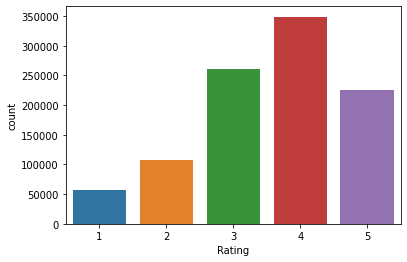

In [13]:
# rating마다 빈도수 시각화
sns.countplot(x='Rating', data=data)
plt.show()

In [14]:
rating_2 = len(data[data['Rating'] > 1])
rating_3 = len(data[data['Rating'] > 2])
print('rating이 2이상인 data 개수 : ', rating_2)
print('rating이 3이상인 data 개수 : ', rating_3)
print('전체 data 개수 : ', len(data))
print('rating이 2이상인 data 퍼센트 : ', (rating_2/len(data))*100)
print('rating이 3이상인 data 퍼센트 : ', (rating_3/len(data))*100)

rating이 2이상인 data 개수 :  944035
rating이 3이상인 data 개수 :  836478
전체 data 개수 :  1000209
rating이 2이상인 data 퍼센트 :  94.38377379127762
rating이 3이상인 data 퍼센트 :  83.63032126285607


rating이 낮은 영화일 경우 추천을 해도 별로일 수 있기 때문에 rating이 낮은 item은 제거한다.

In [15]:
data = data[data['Rating'] > 2]

In [16]:
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('UserId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['UserId'].isin(session_in_train)]
    after_date = data[data['UserId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [17]:
tr, test = split_by_date(data, n_days=120)
tr, val = split_by_date(tr, n_days=120)

In [18]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [19]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 710256
	 Sessions: 5661
	 Items: 3600
	 First Time : 2000-04-25 23:05:32
	 Last Time : 2002-07-02 15:40:10

* valid Set Stats Info
	 Events: 31758
	 Sessions: 106
	 Items: 2835
	 First Time : 2000-04-30 06:37:43
	 Last Time : 2002-10-31 16:33:08

* test Set Stats Info
	 Events: 94429
	 Sessions: 272
	 Items: 3250
	 First Time : 2000-04-27 16:38:08
	 Last Time : 2003-02-28 17:49:50



In [20]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [21]:
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### Step 2. 미니 배치의 구성

실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅자. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성한다.

단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있다.

SessionDatset 클래스를 정의

In [22]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets


In [23]:
#인덱싱을 부여한 데이터셋을 출력하기
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [24]:
#데이터셋의 인덱스에 대한 클릭수 누적
tr_dataset.click_offsets

array([     0,     53,    169, ..., 709861, 709980, 710256], dtype=int32)

In [25]:
#데이터셋의 인덱스 출력
tr_dataset.session_idx

array([   0,    1,    2, ..., 5658, 5659, 5660])

In [26]:
#SessionDataLoader 설정
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [27]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,2
37,1,1022,5,2000-12-31 22:00:55,3
24,1,2340,3,2000-12-31 22:01:43,4
36,1,1836,5,2000-12-31 22:02:52,5
3,1,3408,4,2000-12-31 22:04:35,6
7,1,2804,5,2000-12-31 22:11:59,7
47,1,1207,4,2000-12-31 22:11:59,8
0,1,1193,5,2000-12-31 22:12:40,9


In [28]:
iter_ex = iter(tr_data_loader)

In [29]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 53 64 54]
Label Item Idx are :       [ 1 54 62 24]
Previous Masked Input Idx are []


### Step 3. 모델 구성

실습코드 내역을 참고하여 다양하게 모델 구조를 시도해볼 수 있다.

In [30]:
#Evaluation Metric 모델 평가를 위한 지표 보기
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [31]:
# Model Architecture

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [32]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [33]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=100, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)

In [34]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(100, 1, 3600)]          0         
_________________________________________________________________
GRU (GRU)                    [(100, 50), (100, 50)]    547800    
_________________________________________________________________
dropout (Dropout)            (100, 50)                 0         
_________________________________________________________________
dense (Dense)                (100, 3600)               183600    
Total params: 731,400
Trainable params: 731,400
Non-trainable params: 0
_________________________________________________________________


### Step 4. 모델 학습

다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 하자. 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 하자.

In [35]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [36]:
train_model(model, args)

Train:   0%|          | 0/7045 [00:00<?, ?it/s, accuracy=0.01, train_loss=5.91]

	 - Recall@20 epoch 1: 0.260282
	 - MRR@20    epoch 1: 0.067965



Train:   0%|          | 0/7045 [00:00<?, ?it/s, accuracy=0.04, train_loss=5.57]

	 - Recall@20 epoch 2: 0.336761
	 - MRR@20    epoch 2: 0.093475



Evaluation:  22%|██▏       | 71/316 [00:38<02:13,  1.84it/s]

	 - Recall@20 epoch 3: 0.361972
	 - MRR@20    epoch 3: 0.108912



### Step 5. 모델 테스트

미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 보자.

In [37]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  73%|███████▎  | 690/941 [06:32<02:22,  1.76it/s]

	 - Recall@20: 0.249391
	 - MRR@20: 0.067831



### Step 6. 성능 향상 시도

batch_size, epochs, learning_rate, hidden size, drop rate 변화를 줘서 성능 향상 시도해보기


batch_size 100 -> 50

In [38]:
args1 = Args(tr, val, test, batch_size=50, hsz=50, drop_rate=0.1, lr=0.001, epochs=3, k=20)
model1 = create_model(args1)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(50, 1, 3600)]           0         
_________________________________________________________________
GRU (GRU)                    [(50, 50), (50, 50)]      547800    
_________________________________________________________________
dropout_1 (Dropout)          (50, 50)                  0         
_________________________________________________________________
dense_1 (Dense)              (50, 3600)                183600    
Total params: 731,400
Trainable params: 731,400
Non-trainable params: 0
_________________________________________________________________


In [39]:
train_model(model1, args1)

Train:   0%|          | 0/14091 [00:00<?, ?it/s, accuracy=0.02, train_loss=5.69]

	 - Recall@20 epoch 1: 0.228295
	 - MRR@20    epoch 1: 0.058802



Train:   0%|          | 0/14091 [00:00<?, ?it/s, accuracy=0.02, train_loss=5.54]

	 - Recall@20 epoch 2: 0.273272
	 - MRR@20    epoch 2: 0.075196



Evaluation:  69%|██████▊   | 434/633 [02:04<00:57,  3.47it/s]

	 - Recall@20 epoch 3: 0.289447
	 - MRR@20    epoch 3: 0.082355



epochs 3 -> 10

In [40]:
args2 = Args(tr, val, test, batch_size=100, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)
model2 = create_model(args2)
train_model(model2, args2)

Train:   0%|          | 0/7045 [00:00<?, ?it/s]

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(100, 1, 3600)]          0         
_________________________________________________________________
GRU (GRU)                    [(100, 50), (100, 50)]    547800    
_________________________________________________________________
dropout_2 (Dropout)          (100, 50)                 0         
_________________________________________________________________
dense_2 (Dense)              (100, 3600)               183600    
Total params: 731,400
Trainable params: 731,400
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/7045 [00:00<?, ?it/s, accuracy=0.04, train_loss=5.54]

	 - Recall@20 epoch 1: 0.261690
	 - MRR@20    epoch 1: 0.069232



Train:   0%|          | 0/7045 [00:00<?, ?it/s, accuracy=0.05, train_loss=5.6] 

	 - Recall@20 epoch 2: 0.330704
	 - MRR@20    epoch 2: 0.093508



Train:   0%|          | 0/7045 [00:00<?, ?it/s, accuracy=0.04, train_loss=5.39]

	 - Recall@20 epoch 3: 0.360141
	 - MRR@20    epoch 3: 0.107583



Train:   0%|          | 0/7045 [00:00<?, ?it/s, accuracy=0.05, train_loss=5.45]

	 - Recall@20 epoch 4: 0.369859
	 - MRR@20    epoch 4: 0.112759



Train:   0%|          | 0/7045 [00:00<?, ?it/s, accuracy=0.05, train_loss=5.35]

	 - Recall@20 epoch 5: 0.379859
	 - MRR@20    epoch 5: 0.118247



Train:   0%|          | 0/7045 [00:00<?, ?it/s, accuracy=0.05, train_loss=5.33]

	 - Recall@20 epoch 6: 0.380141
	 - MRR@20    epoch 6: 0.120556



Train:   0%|          | 0/7045 [00:00<?, ?it/s, accuracy=0.03, train_loss=5.25]

	 - Recall@20 epoch 7: 0.383239
	 - MRR@20    epoch 7: 0.122213



Train:   0%|          | 0/7045 [00:00<?, ?it/s, accuracy=0.07, train_loss=4.9] 

	 - Recall@20 epoch 8: 0.389155
	 - MRR@20    epoch 8: 0.123976



Train:   0%|          | 0/7045 [00:00<?, ?it/s, accuracy=0.04, train_loss=5.28]

	 - Recall@20 epoch 9: 0.386197
	 - MRR@20    epoch 9: 0.122628



Evaluation:  22%|██▏       | 71/316 [00:35<02:03,  1.98it/s]

	 - Recall@20 epoch 10: 0.387465
	 - MRR@20    epoch 10: 0.125228



learning_rate 0.001 -> 0.01

In [41]:
args2 = Args(tr, val, test, batch_size=100, hsz=50, drop_rate=0.1, lr=0.01, epochs=3, k=20)
model2 = create_model(args2)
train_model(model2, args2)

Train:   0%|          | 0/7045 [00:00<?, ?it/s]

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(100, 1, 3600)]          0         
_________________________________________________________________
GRU (GRU)                    [(100, 50), (100, 50)]    547800    
_________________________________________________________________
dropout_3 (Dropout)          (100, 50)                 0         
_________________________________________________________________
dense_3 (Dense)              (100, 3600)               183600    
Total params: 731,400
Trainable params: 731,400
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/7045 [00:00<?, ?it/s, accuracy=0.02, train_loss=5.83]

	 - Recall@20 epoch 1: 0.322394
	 - MRR@20    epoch 1: 0.092128



Train:   0%|          | 0/7045 [00:00<?, ?it/s, accuracy=0.03, train_loss=5.83]

	 - Recall@20 epoch 2: 0.329296
	 - MRR@20    epoch 2: 0.095557



Evaluation:  22%|██▏       | 71/316 [00:37<02:08,  1.90it/s]

	 - Recall@20 epoch 3: 0.333944
	 - MRR@20    epoch 3: 0.098144



hidden size 50 - > 100

In [42]:
args3 = Args(tr, val, test, batch_size=100, hsz=100, drop_rate=0.1, lr=0.001, epochs=3, k=20)
model3 = create_model(args3)
train_model(model3, args3)

Train:   0%|          | 0/7045 [00:00<?, ?it/s]

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(100, 1, 3600)]          0         
_________________________________________________________________
GRU (GRU)                    [(100, 100), (100, 100)]  1110600   
_________________________________________________________________
dropout_4 (Dropout)          (100, 100)                0         
_________________________________________________________________
dense_4 (Dense)              (100, 3600)               363600    
Total params: 1,474,200
Trainable params: 1,474,200
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/7045 [00:00<?, ?it/s, accuracy=0.05, train_loss=5.29]

	 - Recall@20 epoch 1: 0.307606
	 - MRR@20    epoch 1: 0.085551



Train:   0%|          | 0/7045 [00:00<?, ?it/s, accuracy=0.04, train_loss=5.11]

	 - Recall@20 epoch 2: 0.352817
	 - MRR@20    epoch 2: 0.108975



Evaluation:  22%|██▏       | 71/316 [00:36<02:05,  1.94it/s]

	 - Recall@20 epoch 3: 0.373239
	 - MRR@20    epoch 3: 0.119432



drop rate 0.1 -> 0.5

In [43]:
args4 = Args(tr, val, test, batch_size=100, hsz=50, drop_rate=0.5, lr=0.001, epochs=3, k=20)
model4 = create_model(args4)
train_model(model4, args4)

Train:   0%|          | 0/7045 [00:00<?, ?it/s]

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(100, 1, 3600)]          0         
_________________________________________________________________
GRU (GRU)                    [(100, 50), (100, 50)]    547800    
_________________________________________________________________
dropout_5 (Dropout)          (100, 50)                 0         
_________________________________________________________________
dense_5 (Dense)              (100, 3600)               183600    
Total params: 731,400
Trainable params: 731,400
Non-trainable params: 0
_________________________________________________________________


Train:   0%|          | 0/7045 [00:00<?, ?it/s, accuracy=0.03, train_loss=6.24]

	 - Recall@20 epoch 1: 0.228451
	 - MRR@20    epoch 1: 0.059416



Train:   0%|          | 0/7045 [00:00<?, ?it/s, accuracy=0.04, train_loss=5.46]

	 - Recall@20 epoch 2: 0.304225
	 - MRR@20    epoch 2: 0.083996



Evaluation:  22%|██▏       | 71/316 [00:37<02:09,  1.90it/s]

	 - Recall@20 epoch 3: 0.332817
	 - MRR@20    epoch 3: 0.096980



In [44]:
test_model(model1, args1, test)

Evaluation:  86%|████████▋ | 1628/1883 [08:03<01:15,  3.37it/s]

	 - Recall@20: 0.244361
	 - MRR@20: 0.068115



In [45]:
test_model(model2, args2, test)

Evaluation:  73%|███████▎  | 690/941 [06:30<02:22,  1.77it/s]

	 - Recall@20: 0.226420
	 - MRR@20: 0.061294



In [46]:
test_model(model3, args3, test)

Evaluation:  73%|███████▎  | 690/941 [06:24<02:19,  1.80it/s]

	 - Recall@20: 0.262783
	 - MRR@20: 0.075131



In [47]:
test_model(model4, args4, test)

Evaluation:  73%|███████▎  | 690/941 [06:28<02:21,  1.78it/s]

	 - Recall@20: 0.232000
	 - MRR@20: 0.060493



### 회고

이번 노드도 기존 예제를 따라 최대한 이해하려고 하면서 진행하였으며 앞선 예제를 통해서 프로젝트를 진행하였지만 처음 모델링 부분에서 여러번 에러를 발생하며 진행하지 못하여 포기하려던 차에 기존 예제노드에서 Test set과 Valid set을 1일로 잡은것과는 다르게 1일로 잡을경우 데이터가 너무 작아서였는지 2개월분의 데이터 120일로 수정하라는 조언과 batch_size를 2048에서 128 이하로 낮춰야 모델링에 성공한다는 조언을 듣고 재시도하여 batch_size를 100으로 낮췄더니 모델링이 성공적으로 완료되는것을 확인할수 있었다. 왜 batch_size를 낮춰줘야 하는지는 아직 확실히 이해하지 못하고 넘어가서 추후 노드를 다시 볼 기회(스터디)에 좀더 자세히 확인할 예정이다.

실습과 프로젝트의 Time 데이터셋 형이 틀려 형변환 해서 진행햇으며 최종 30일 이전 데이터를 확인햇을때도 데이터가 현저히 적어 전체데이터를 사용하기로 하였다.

추천시스템에서 rating이 1인 경우는 신뢰할수 없어서 2이상일때와 3이상일때의 데이터양을 확인해보았으며 각각 94%, 83%를 차지하고 있었으나. 이전에 진행햇던 추천시스템 노드에서 3이상의 경우 신뢰데이터로 사용했던 적이 있어서 3이상 데이터만 사용하고 나머지 데이터는 버렸다.

모델구성은 앞선 예제를 참조하여 진행하였으며 n_days=120, batch_size를 100으로 했을때 모델이 성공적으로 모델링을 완료할수 있어서 초기값은 그렇게 지행하여 모델링 완료후 테스트 과정을 거쳐 완료했다.

성능향상 시도로 batch_size, epochs, learning_rate, hidden size, drop rate 변화를 줘봤으며, batch_size를 더 낮췄을때 학습시간은 더 오래 걸렸지만 train_loss 값은 더 낮아졌으며, epochs 을 10회 늘렸을때엔 크게 별 차이를 못느꼈다. learning rate 역시 크게 변화를 못느꼈으며, hidden size와 drop rate 를 변화줘 봤지만 별 차이점을 모르겠다...

그나마 batch_size를 낮춘게... 조금 결과값이 나아진것처럼 보인다..